# ANOVA



In [21]:
import pandas as pd
from statsmodels.formula.api import ols

kids = pd.read_csv("https://github.com/febse/data/raw/main/econ/childiq.csv")[["kid_score", "mom_hs"]]
kids.head()

,kid_score,mom_hs
0,65,1
1,98,1
2,85,1
3,83,1
4,115,1


Beschreibung der Variablen in der Datei `kids.csv`:

-   `kid_score`: (numeric) Punkte im IQ-Test
-   `mom_hs` (numeric): 1 falls die Mutter des Kindes einen High School Abschluss hat, 0 sonst

In dieser Aufgabe werden wir annehmen, dass die Kinder rein zufällig aus allen Kindern im Alter zwischen 3 und 5 Jahren in den USA ausgewählt wurden (zur Zeit der Untersuchung).

Wir möchten die folgende Forschungsfrage untersuchen: Erreichen Kinder, deren Mutter keinen High School Abschluss hat, im Durchschnitt niedrigere IQ-Werte als Kinder, deren Mutter einen High School Abschluss hat?

/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Bildung der Mutter')

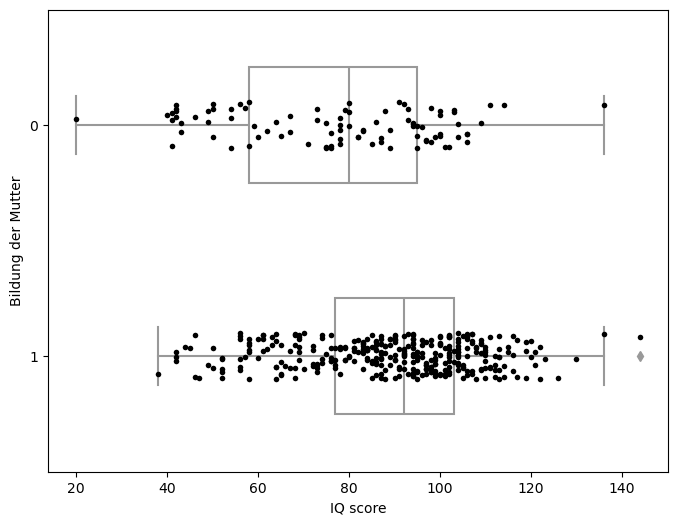

In [22]:
#| label: fig-kid-score-plot
#| fig-cap: "IQ scores of the children by the status of their mother (high school degree/no high school degree).  The plot adds a small amount of noise to the observations to avoid overplotting."

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming kids is a pandas DataFrame
kids['mom_hs'] = kids['mom_hs'].astype('category')

plt.figure(figsize=(8, 6))
sns.boxplot(x='kid_score', y='mom_hs', data=kids, color='white', width=0.5)
sns.stripplot(x='kid_score', y='mom_hs', data=kids, size=4, jitter=True, color='black')
plt.xlabel('IQ score')
plt.ylabel("Bildung der Mutter")

In [23]:
# Berechnen Sie die durchschnittlichen IQ-Scores für Kinder, deren Mütter einen High-School-Abschluss haben, und für Kinder,
# deren Mütter keinen High-School-Abschluss haben.



## Das Modell

$$
\begin{align*}
& i = 1,\ldots, n = 434 \text{ observations}\\
& y_i: \text{IQ score} \\
& \hat{y}_i: \text{Predicted IQ score} \\
& x_i \in \{0, 1\}: \text{status of the mother}
\end{align*}
$$

$$
y_i = \beta_0 + \beta_1 x_i + e_i, e_i \sim N(0, \sigma^2)
$$


$$
\begin{align*}
& y_i \sim N(\mu_i, \sigma^2), \quad i = 1,\ldots,n \\
& \mu_i = \beta_0 + \beta_1 x_i, \quad x_i \in \{0, 1\}
\end{align*}
$$ {#eq-simple-anova}

$$
\mu_1 = \beta_0 + \beta_1 \cdot 1
$$ {#eq-mu-x-1}

Für $x = 0$

$$
\mu_0 = \beta_0 + \beta_1 \cdot 0
$$ {#eq-mu-x-0}

Die Differenz der zwei Gleichungen [-@eq-mu-x-1] und [-@eq-mu-x-0] ergibt:

$$
\begin{align*}
\beta_0 & = \mu_0 \\
\beta_1 & = \mu_1 - \mu_0
\end{align*}
$$ 

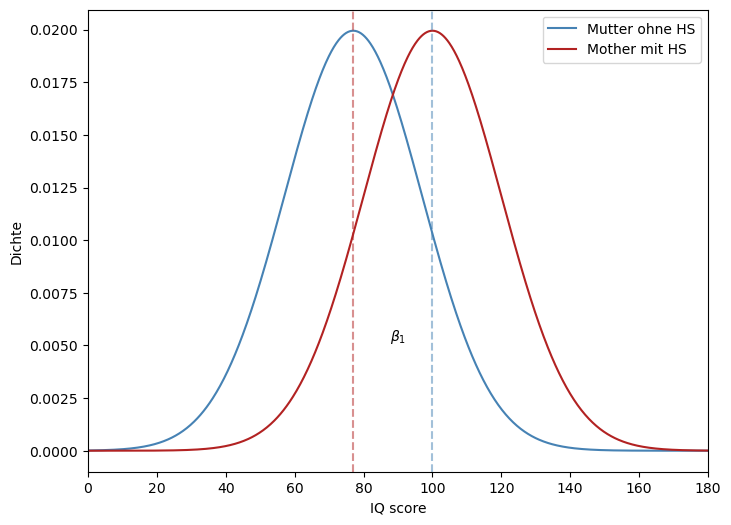

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the range of x
x = np.linspace(0, 180, 1000)

# Calculate the densities of the normal distributions
y1 = norm.pdf(x, loc=77, scale=20)
y2 = norm.pdf(x, loc=100, scale=20)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y1, color='steelblue', label='Mutter ohne HS')
plt.plot(x, y2, color='firebrick', label='Mother mit HS')
plt.axvline(x=77, linestyle='--', alpha=0.5, color='firebrick')
plt.axvline(x=100, linestyle='--', alpha=0.5, color='steelblue')
plt.text(90, 0.005, r'$\beta_1$', verticalalignment='bottom', horizontalalignment='center')
plt.xlim([0, 180])
plt.xlabel('IQ score')
plt.ylabel('Dichte')
plt.legend(loc='upper right')

Berechnen Sie die Koeffizienten der folgenden Prognosegleichung für den IQ-Wert eines Kindes:

$$
\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 \cdot x
$$

wobei $y$ der IQ-Wert des Kindes ist, $x$ die Variable `mom_hs` und $\hat{y}$ die Prognose für den IQ-Wert ist. Benutzen Sie
[https://febse.github.io/econ2024-de/03-KQ-Methode.html#%C3%BCbung](https://febse.github.io/econ2024-de/03-KQ-Methode.html#%C3%BCbung)

## Simulation

Um die statistischen Eigenschaften der KQ-Schätzer für die Koeffizienten zu untersuchen, führen wir eine Simulation durch. Wir werden die folgenden Schritte durchführen:

1. Wir generieren $n = 434$ Beobachtungen für die IQ-Werte der Kinder und die Variable `mom_hs` basierend auf dem Modell

$$
\begin{align*}
& y_i = 80 + 15 x_i + e_i, e_i \sim N(0, 20^2) \\
& x_i \in \{0, 1\}
\end{align*}
$$


In [25]:
np.random.seed(123)

# Die Anzahl der Stichproben
B = 1000

# Die Anzahl der Beobachtungen pro Stichprobe
N = 434

# 
e = np.random.normal(loc=0, scale=20, size=N * B)

# Für jedes Kind wir der Bildungsstatus der Mutter zufällig generiert
# so dass circa 80% der Mütter einen High-School-Abschluss haben

x = np.random.binomial(n=1, p=0.8, size=N * B)

y = 80 + 15*x + e
sim_id = np.repeat(np.arange(1, B+1), N)

dt = pd.DataFrame({'sim_id': sim_id, 'kid_score': y, 'mom_hs': x})

# Fit the models


def fit_ols(dat):
    fit = ols('kid_score ~ mom_hs', dat).fit()

    return pd.Series({
        'intercept': fit.params['Intercept'],
        'intercept_se': fit.bse['Intercept'],
        'slope': fit.params['mom_hs'],
        'slope_se': fit.bse['mom_hs']
    })

sim = dt.groupby('sim_id').apply(fit_ols)

:::{#exr-simulation-first-sample}
Benutzen Sie die Daten der ersten Stichprobe aus der Simulation, um die Koeffizienten $\beta_0$ und $\beta_1$ zu schätzen.
*Hinweis*: Benutzen Sie die Funktion `ols` aus dem Paket `statsmodels` in Python.

:::

## Verteilung der Koeffizienten


/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/scipy/stats/_kde.py:588: RuntimeWarning: invalid value encountered 

Text(0.5, 0, 'Slope ($\\hat{\\beta}_1$)')

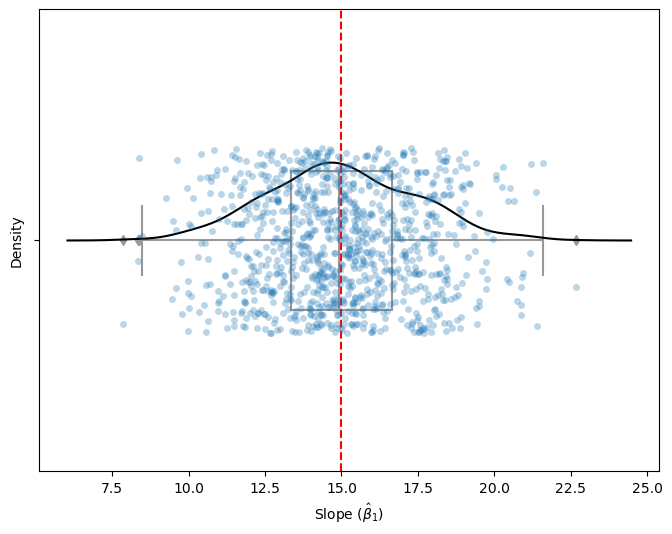

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.stripplot(x='slope', data=sim, jitter=0.2, alpha=0.3, ax=ax)
sns.boxplot(x='slope', data=sim, ax=ax, color='white', width=0.3)
plt.axvline(x=15, color='red', linestyle='--')
sns.kdeplot(x='slope', data=sim, color='black', bw_adjust=-1)

ax.set_xlabel(r"Slope ($\hat{\beta}_1$)")


In [27]:
sim["slope"].mean()

14.979094621402096

In [28]:
sim["slope"].std()

2.3983789144793057

In [29]:
sample_1 = dt[dt["sim_id"] == 1]

ols('kid_score ~ mom_hs', data=sample_1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              kid_score   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     25.90
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           5.38e-07
Time:                        15:07:37   Log-Likelihood:                -1913.3
No. Observations:                 434   AIC:                             3831.
Df Residuals:                     432   BIC:                             3839.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.6852      2.241     35.996      0.000      76.280      85.091
mom_hs        12.6123      2.478      5.089      0.000       7.741      17.483
==============================================================================
Omnibus:                        0.192   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.908   Jarque-Bera (JB):                0.216
Skew:                           0.051   Prob(JB):                        0.898
Kurtosis:                       2.959   Cond. No.                         4.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Hypothesentests

-   Testen Sie die Nullhypothese, dass der Koeffizient $\beta_1$ gleich 0 ist gegen die Alternative, dass $\beta_1$ größer als 0 ist.

$$
\begin{align*}
H_0: & \beta_1 \leq 0 \\
H_1: & \beta_1 > 0
\end{align*}
$$

-   Testen Sie die Nullhypothese, dass der Koeffizient $\beta_0$ gleich 15 ist gegen die Alternative, dass $\beta_0$ grösser als 15 ist.

$$
\begin{align*}
H_0: & \beta_1 \leq 15 \\
H_1: & \beta_1 > 15
\end{align*}
$$

Berechnen Sie die Teststatistik in jeder Stichprobe

$$
t = \frac{\hat{\beta}_1 - \beta_1^{H_0}}{\text{SE}(\hat{\beta}_1)}
$$

für beide Hypothesen.

In [30]:
# Berechnen Sie die t-statistik für die Nullhypothese H_0: \beta_1 >= 15

t_stat_1 = (sim["slope"] - 15) / sim["slope_se"]

/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/scipy/stats/_kde.py:588: RuntimeWarning: invalid value encountered 

<Axes: ylabel='Density'>

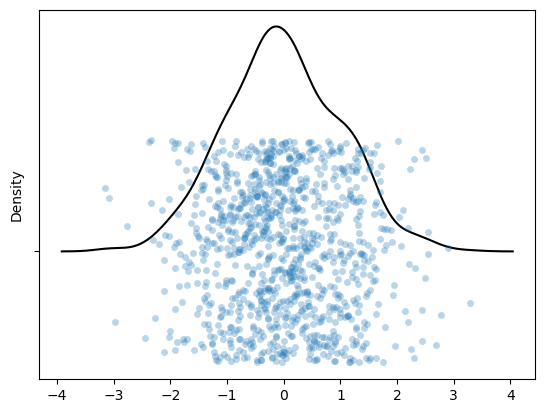

In [36]:
# Visualisieren Sie die Verteilung der t-Statistiken mittels eines strip plots und einer Kerndichteschätzung.

sns.stripplot(x=t_stat_1, jitter=0.2, alpha=0.3)
sns.kdeplot(x=t_stat_1, color='black', bw_adjust=-1)

In [ ]:
# In wie vielen Stichproben ist die t-Statistik kleiner als -2?


Man kann zeigen, dass under der Nullhypothese $t$ eine $t$-Verteilung mit $n - p$ Freiheitsgraden hat. Dabei ist $n$ die Anzahl der Beobachtungen und $p$ die Anzahl der Koeffizienten im Regressionsmodell.

$$
t \sim t(n - p)
$$


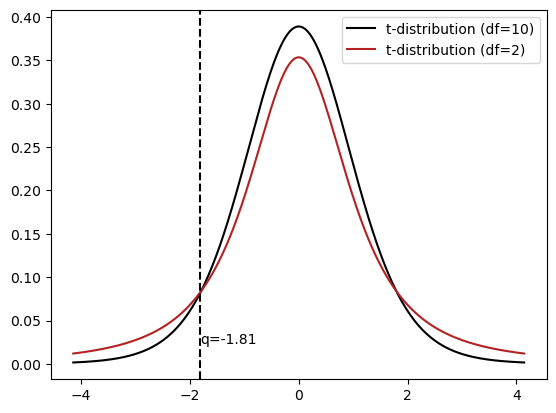

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# Define the degrees of freedom and the quantiles
df = 10
quantiles = [0.05]

# Compute the t-distribution density
x = np.linspace(t.ppf(0.001, df), t.ppf(0.999, df), 1000)
y = t.pdf(x, df)
y1 = t.pdf(x, df=2)

# Compute the quantiles
q_values = t.ppf(quantiles, df)

# Plot the density
plt.plot(x, y, label=f't-distribution (df={df})', color='black')
plt.plot(x, y1, label=f't-distribution (df=2)', color='firebrick')

# Add vertical lines and annotations for the quantiles
for q in q_values:
    plt.axvline(q, color='black', linestyle='--')
    plt.text(q, 0.02, f'q={q:.2f}', verticalalignment='bottom', horizontalalignment='left')

plt.legend(loc='upper right')
plt.show()

Im `scipy` Paket gibt es die Funktion `t.ppf` (percent point function), mit der wir Quantile von $t$-Verteilungen berechnen können. Die Funktion hat zwei Argumente: die Wahrscheinlichkeit und die Anzahl der Freiheitsgrade. Zum Beispiel, um das 95% Quantil der $t$-Verteilung mit 10 Freiheitsgraden zu berechnen, benutzen wir den folgenden Code:

```python 
from scipy.stats import t
t.ppf(0.95, 10)
```


In [66]:
t.ppf(0.025, df=10)

-2.2281388519649385

In [47]:
t.cdf(-2.2281388519649385, df=10)

0.02500000000090431

In [43]:
t.ppf(0.975, df=10)

2.2281388519649385

In [50]:
t.cdf(2.2281388519649385, df=10)

0.9749999999990957

In [59]:
t.ppf(0.05, df=433)

-1.6483803112711266

In [65]:
# Nehmen Sie an, dass wir die Nullhypothese für Werte der t-Statistik kleiner als das 0.05 Quantil der t-Verteilung (mit den entsprechen Freiheitsgraden) ablehnen.
# In wie vielen Stichproben werden wir eine falsche Entscheidung treffen?

np.sum(t_stat_1 < t.ppf(0.05, df=433))

49

Der p-Wert (p-value) ist die Wahrscheinlichkeit, dass die Teststatistik $t$ extremer (d.h. in der Alternative) ist als der beobachtete Wert. In unserem Beispiel
ist es die Wahrscheinlichkeit, dass $t$ kleiner als die beobachtete Teststatistik ist, wenn die Nullhypothese wahr ist.

$$
p = P(t \leq t_{\text{obs}} | H_0)
$$

Beachten Sie, dass die t-Statistik von den Daten abhängt und daher in jeder Stichprobe unterschiedlich ist. Daher ist auch der p-Wert in jeder Stichprobe unterschiedlich.

In [63]:
# Berechnen Sie die p-Werte für die t-Statistiken aus der Simulation für die Nullhypothese H_0: \beta_1 >= 15

p_values_1 = 1 - t.cdf(t_stat_1, df=434 - 2)


In [64]:
# In wie vielen Stichproben ist der p-Wert kleiner als 0.05?

np.sum(p_values_1 < 0.05)

45

:::{#exr-simulation-hypothesis-test}
## Übungsaufgabe

Für die Nullhypothese

$$
\begin{align*}
H_0: \beta_1 <= 0 \\
H_1: \beta_1 > 0
\end{align*}
$$

- Berechnen Sie die Teststatistik $t$ in jeder Stichprobe
- Berechnen Sie den p-Wert in jeder Stichprobe
- Zählen Sie die Anzahl der Stichproben, in denen der p-Wert kleiner als 0.05 ist. Dies ist die Anzahl der Stichproben, in denen wir die Nullhypothese ablehnen würden.
- Falls Sie die Nullhypothese für p-Werte kleiner als 0.05 verwerfen, berechnen Sie den Anteil der Stichproben, in denen Sie eine falsche Entscheidung treffen
- Berechnen Sie den kritischen Wert für diese Hypothese bei einem Signifikanzniveau von 0.01.
:::

:::{#exr-simulation-hypothesis-test-two-sided}

## Übungsaufgabe

Für die Nullhypothese

$$
\begin{align*}
H_0: & \beta_0 = 0 \\
H_1: & \beta_0 \neq 0
\end{align*}
$$

- Berechnen Sie die Teststatistik $t$ in jeder Stichprobe
- Berechnen Sie den p-Wert in jeder Stichprobe
- Zählen Sie die Anzahl der Stichproben, in denen der p-Wert kleiner als 0.05 ist. Dies ist die Anzahl der Stichproben, in denen wir die Nullhypothese ablehnen würden.
- Falls Sie die Nullhypothese für p-Werte kleiner als 0.05 verwerfen, berechnen Sie den Anteil der Stichproben, in denen Sie eine falsche Entscheidung treffen
- Berechnen Sie die kritische Werte für diese Hypothese bei einem Signifikanzniveau von 0.1. Achten Sie darauf, dass Sie hier sowohl für zu große als auch zu kleine Werte der Teststatistik ablehnen müssen.
:::

## Anhang

Wie können wir den Erwartungswert und die Varianz der Schätzer für $\beta_0$ und $\beta_1$ berechnen?

Wir können die Formel für $\hat{\beta}_1$ als eine Linearkombination von $y_i$ schreiben:

$$
\begin{align*}
\hat{\beta}_1 & = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
& = \frac{\sum_{i=1}^{n}(x_i - \bar{x})y_i}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
& = \sum_{i = 1}^{n} w_i y_i
\end{align*}
$$

Das dürfen wir tun, denn es gilt:

$$
\begin{align*}
\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y}) & = \sum_{i=1}^{n}(x_i - \bar{x})y_i + \sum_{i=1}^{n}(x_i - \bar{x})\bar{y} \\
& = \sum_{i=1}^{n}(x_i - \bar{x})y_i + \bar{y}\sum_{i=1}^{n}(x_i - \bar{x}) \\
& = \sum_{i=1}^{n}(x_i - \bar{x})y_i
\end{align*}
$$

Der bedingte Erwartungswert von $\hat{\beta}_1$ gegeben $x$ ist:

$$
\begin{align*}
E(\hat{\beta}_1 | x) & = E\left(\sum_{i = 1}^{n} w_i y_i | x \right) \\
& = \sum_{i = 1}^{n} w_i E(y_i | x) \\
& = \sum_{i = 1}^{n} w_i \mu_i \\
& = \sum_{i = 1}^{n} w_i (\beta_0 + \beta_1 x_i) \\
& = \beta_0 \sum_{i = 1}^{n} w_i + \beta_1 \sum_{i = 1}^{n} w_i x_i \\
\end{align*}
$$

Die Summe der Koeffizienten $w_i$ ist gleich 0, weil:

$$
\begin{align*}
\sum_{i = 1}^{n} w_i & = \frac{\sum_{i=1}^{n}(x_i - \bar{x})}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
& = \frac{\sum_{i=1}^{n}x_i - n\bar{x}}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
& = \frac{n\bar{x} - n\bar{x}}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
& = 0
\end{align*}
$$

Der Factor vor $\beta_1$ ist:

$$
\begin{align*}
\sum_{i = 1}^{n} w_i x_i & = \frac{\sum_{i=1}^{n}(x_i - \bar{x})x_i}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
\end{align*}
$$

und ist gleich 1, weil:

$$
\begin{align*}
\sum_{i = 1}^{n} (x_i - \bar{x})^2 = \sum_{i = 1}^{n} (x_i - \bar{x})x_i
\end{align*}
$$

Am Ende erhalten wir:

$$
\begin{align*}
E(\hat{\beta}_1 | x) & = \beta_1
\end{align*}
$$


Die bedingte Varianz von $\hat{\beta}_1$ gegeben $x$ ist:

$$
\begin{align*}
\text{Var}(\hat{\beta}_1 | x) & = \text{Var}\left(\sum_{i = 1}^{n} w_i y_i | x \right) \\
& = \sum_{i = 1}^{n} w_i^2 \text{Var}(y_i | x) \\
& = \sum_{i = 1}^{n} w_i^2 \sigma^2 \\
& = \sigma^2 \sum_{i = 1}^{n} w_i^2
\end{align*}
$$

Um auf diese Formel zu kommen, haben wir vorausgesetzt, dass gegeben $x$, die Beobachtungen unkorreliert sind. Wenn wir die Summe der quadrierten Koeffizienten $w_i$ vereinfachen, erhalten wir

$$
\begin{align*}
\sum_{i = 1}^{n} w_i^2 & = \sum_{i = 1}^{n} \frac{(x_i - \bar{x})^2}{(\sum_{i=1}^{n}(x_i - \bar{x})^2)^2} \\
& = \frac{\sum_{i = 1}^{n}(x_i - \bar{x})^2}{(\sum_{i=1}^{n}(x_i - \bar{x})^2)^2} \\
& = \frac{1}{\sum_{i=1}^{n}(x_i - \bar{x})^2}
\end{align*}
$$

Insgesamt erhalten wir:

$$
\begin{align*}
\text{Var}(\hat{\beta}_1 | x) & = \frac{\sigma^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}
\end{align*}
$$


